## Defining the dispersal function

The probability of dispersal for the animal will be a defined as _Dispersal ~ f(Cost + Distance)_.
The **Cost** is defined by the current density value which is scaled from 0-1. The **Distance** will follow an exponential decay function where there is a higher probability of an animal dispersing to areas closer to their starting point than areas farther from the starting point.

**Note:** Currently, the functions for **Cost** and **Distance** are running seperately and not as a joint function. I am continuing to work on this so that dispersal is an outcome of both the resistance of the surface to movement and the distance as an exponential decay from the animals starting point. 
<br>**Step 4** is not currently functioning. 

### Workflow of Simulating Dispersal
1. Get animals starting point
2. Draw dispersal probabilities
3. Update the simulation with randomly drawn binomial successes 
4. Repeat steps 2-3 until end of simulation

In [69]:
# MatPlotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pylab
from matplotlib.colors import LinearSegmentedColormap

# Scientific libraries
import numpy as np
from scipy.optimize import curve_fit

# Plotting Library
import toyplot

# Spatial Analyses
from osgeo import gdal

# Import raster file produced from notebook 1
circ = '/Users/meredithvanacker/PDSB/PDSB-Project/data/new_circuit.tif'

### Opening Raster File

In [70]:
dataset = gdal.Open(circ)
if dataset is None:
    print('Could not open image')
    sys.exit(1)
dataset

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x153077a6f0> >

### Check Visualization and shape 

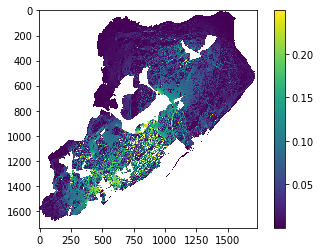

In [71]:
p = dataset.ReadAsArray()
masked_array = np.ma.masked_inside(p, 0.00, 0.00000000000001)
plt.imshow(masked_array)
plt.colorbar()

In [72]:
p.shape

(1734, 1734)

## 1. Starting Points

In [73]:
# get starting point
start = np.zeros((1734, 1734)) # set the array the same size as the raster file
start[0, 0] = 1
start

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## 2. Dispersal Probabilities

### Dispersal defined by cost surface.

 This is the dispersal probability based on the current density values from circuitscape. The current densities are divided by the maximum value to scale the dispersal probability to be between 0 and 1. 

In [74]:
def cost_prob(x, y):
    rows = p.shape[0]
    cols = p.shape[1]
    denom = p.max() 
    result = np.empty((p.shape))
    for i in range(rows): # loop  through row number
        for j in range(cols): # loop through columns
            result[i,j] = (p[i,j]/denom) # this is the cost - lower probability with higher cost
    #np.savetxt("result.csv", result, fmt='%.2f', delimiter=",") # if you would like to look at the result data
    return result

In [75]:
# Test the function 
x1 = cost_prob(1000,1000)
x1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [76]:
x1.min()

0.0

In [77]:
x1.max()

1.0

In [78]:
x1.shape

(1734, 1734)

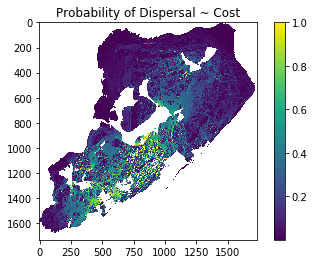

In [80]:
masked_array3 = np.ma.masked_inside(x1, 0.0, 0.0000001)
plt.imshow(masked_array3)
plt.title('Probability of Dispersal ~ Cost')
plt.colorbar()
plt.show()

Higher probabilty of dispersal with higher values. 

### Dispersal defined by exponential decay.

First lets visualize how the decay values would be distributed.

In [81]:
import toyplot
position = 20
canvas = toyplot.Canvas(width=600, height=400)
axes = canvas.cartesian(label="", xlabel="Distance", ylabel="Probability of Movement")
axes.plot(np.exp(-0.2 * abs(np.array(list(range(100))) - position )))

<path d="M 50.0 344.50530833337973 L 55.0 343.2887684431504 L 60.0 341.8028832658122 L 65.0 339.98801901190217 L 70.0 337.7713388064902 L 75.0 335.0638794896408 L 80.0 331.7569812124346 L 85.0 327.7179265356998 L 90.0 322.7846140131762 L 95.0 316.7590524912998 L 100.0 309.39941502901615 L 105.0 300.41033353352407 L 110.0 289.4310446016034 L 115.0 276.02091081751803 L 120.00000000000001 259.64173642633943 L 125.0 239.63616764856732 L 130.0 215.20131076483352 L 135.0 185.35650917179208 L 140.0 148.9039861893082 L 145.0 104.38077407660546 L 150.0 50.0 L 155.0 104.38077407660546 L 160.0 148.9039861893082 L 165.0 185.35650917179208 L 170.0 215.20131076483352 L 175.0 239.63616764856732 L 180.0 259.64173642633943 L 185.0 276.02091081751803 L 190.00000000000003 289.4310446016034 L 195.0 300.41033353352407 L 200.0 309.39941502901615 L 205.0 316.7590524912998 L 210.0 322.7846140131762 L 215.0 327.7179265356998 L 220.0 331.7569812124346 L 225.0 335.0638794896408 L 230.0 337.7713388064902 L 235.0 339.98801901190217 L 240.0 341.8028832658122 L 245.0 343.2887684431504 L 250.0 344.50530833337973 L 255.0 345.5013269538567 L 260.0 346.3167980290795 L 265.0 346.98444927660995 L 270.0 347.531075885294 L 275.0 347.97861590027435 L 280.0 348.34503067377176 L 285.0 348.6450257172162 L 290.0 348.8906408850551 L 295.0 349.09173357638724 L 300.0 349.2563743470001 L 305.0 349.3911708091113 L 310.0 349.5015328180478 L 315.0 349.5918895887356 L 320.0 349.66586745564655 L 325.0 349.72643541033364 L 330.00000000000006 349.776024257487 L 335.0 349.81662417166115 L 340.0 349.84986456996785 L 345.0 349.8770795063061 L 350.0 349.89936121162924 L 355.0 349.91760392900835 L 360.0 349.93253980274636 L 365.0 349.94476826189975 L 370.0 349.95478007747136 L 375.0 349.962977058774 L 380.0 349.9696881794489 L 385.0 349.975182780333 L 390.0 349.97968137905275 L 394.99999999999994 349.98336452017037 L 400.0 349.9863800210712 L 405.0 349.9888489043948 L 410.0 349.9908702550975 L 415.0 349.9925251970805 L 420.0 349.99388014897664 L 425.0 349.99498948976293 L 430.0 349.99589774118033 L 435.0 349.9966413545472 L 440.0 349.9972501736791 L 445.0 349.9977486326255 L 450.0 349.998156736294 L 455.00000000000006 349.99849086331784 L 460.0 349.99876442338774 L 465.0 349.99898839542976 L 470.0 349.9991717682284 L 475.0 349.9993219011779 L 480.0 349.9994448196407 L 485.0 349.9995454567663 L 490.0 349.999627851476 L 495.0 349.9996953105587 L 500.0 349.99975054138423 L 505.0 349.99979576055966 L 510.0 349.9998327828892 L 515.0 349.99986309420893 L 520.0 349.9998879110186 L 525.0 349.99990822930386 L 530.0 349.99992486450884 L 535.0 349.9999384842627 L 540.0 349.99994963517406 L 545.0 349.99995876476817" style="stroke:rgb(40%,76.1%,64.7%);stroke-opacity:1.0;stroke-width:2.0"> 0 50 100 Distance 0.0 0.5 1.0 Probability of Movement

If the animals hypothetical position is at 20 within the array of starting positions, the probability of movement should be higher in areas much closer to the current position than those farther away. 

This is the dispersal probability based on the distance determined by the exponential decay function. The values are expected to be lower closer to the starting position and higher as distance increases.

In [82]:
def exp_disp(x, y, decay):
    grid = np.zeros((p.shape[0], p.shape[1]))
    for row in range(grid.shape[0]):
        grid[row] += (1 - np.exp(-decay * abs(np.array(list(range(p.shape[0]))) - x)))
    for col in range(grid.shape[1]):
        grid[col] += (1 - np.exp(-decay * abs(np.array(list(range(p.shape[1]))) - y)))
    return grid

In [84]:
# Test the function 
x2 = exp_disp(x = 1000, y = 1000, decay = 0.0006) # the decay value can be adjusted to try out how this value changes the results.
x2

array([[0.90237673, 0.90171796, 0.90105879, ..., 0.71012259, 0.71089629,
        0.71166952],
       [0.90237673, 0.90171796, 0.90105879, ..., 0.71012259, 0.71089629,
        0.71166952],
       [0.90237673, 0.90171796, 0.90105879, ..., 0.71012259, 0.71089629,
        0.71166952],
       ...,
       [0.90237673, 0.90171796, 0.90105879, ..., 0.71012259, 0.71089629,
        0.71166952],
       [0.90237673, 0.90171796, 0.90105879, ..., 0.71012259, 0.71089629,
        0.71166952],
       [0.90237673, 0.90171796, 0.90105879, ..., 0.71012259, 0.71089629,
        0.71166952]])

In [85]:
# Multiply to combine the cost and exponential decay functions 

fulldisp = np.multiply(x1, x2)
fulldisp = 1-fulldisp

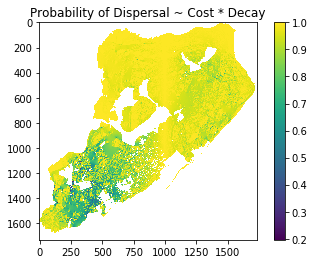

In [90]:
masked_array5 = np.ma.masked_inside(fulldisp, 0.99999999999,1)
plt.imshow(masked_array5)
plt.title('Probability of Dispersal ~ Cost * Decay')
plt.colorbar()
plt.show()

This is showing the dispersal probabilty values from the (1000,1000) position with a decay value of 0.0006. The dispersal probability based on cost was multiplied by the probability from the exponential function. This shows the areas that are higher cost and farther away from (1000,1000) have darker colors which is what would be expected whereas the area around the starting position have lighter colors showing a higher probabilty of dispersal. 

### 3. Binomial distribution determines movement

In [18]:
def move(grid, disp):
    movement = np.random.binomial(1, disp) # "probability of success" determined by dispersal function output
    possible = np.where(movement==1) # count of successful moves
    howmany = len(possible[0]) 
    print howmany # print how many possible moves there are (how many successes are pulled from binomial distribution)
    if howmany:
        which = np.random.choice(range(howmany)) # take a random sample from range of possible moves. 
        newposition = (possible[0][which], possible[1][which])
        grid[np.where(grid==1)] = 0 # conditions to leave old position
        grid[newposition, time] = 1 # conditions to enter new position
    else:
        pass 
    return grid

### Test the move function with cost dispersal probability

In [19]:
time = 10 # number of time points 
grid = np.zeros((1734, 1734, time))
t1 = move(grid, disp = x1) # x1 is the array of dispersal probabilties determined by cost
t1

2773546


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [20]:
t1.ndim

3

In [21]:
t1.shape
# t1 now has 3 dimensions with 10 arrays of size (1734, 1734)

(1734, 1734, 10)

Look at the frequency of zeros and ones in the first array.

In [22]:
t1sub = t1[:, :, 1]
counts = np.unique(t1sub, return_counts=True)
counts

(array([0., 1.]), array([3006754,       2]))

### Test the move function with exponential decay dispersal probability

In [23]:
time = 10 # number of time points 
grid = np.zeros((1734, 1734, time))
t2 = move(grid, disp = x2)# x2 is the array of dispersal probabilties determined by distance.
t2

1346238


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [24]:
t2sub = t2[:, :, 1]
counts = np.unique(t2sub, return_counts=True)
counts

(array([0., 1.]), array([3006754,       2]))

#### _Current Issues_

The number of zero and non-zero counts from using the exp_dist and cost_prob function as inputs into the move function are the same although the number of possible successes (or ones pulled from the binomial distriution) are different from these two functions as seen with the _print howmany_ argument. I am working to figure out why this is.

## 4. Loop through Steps 2 and 3 for multiple dispersal events. 

In [25]:
# Step 1:
# Set the starting position for the animal
grid = np.zeros((1734, 1734))
grid[0, 0] = 1
N = 10

# draw 10 movements
for i in range(N):
    # Step 2:
    # Estimate the dispersal probability where dispersal ~ f(Cost + Distance) 
    disp = dispersal() # this will be one new function that combines the cost_prob and exp_disp functions above
    
    # Step 3:
    # draw new moves from binomial distribution 
    move(grid, disp)
    
    # Step 4:
    # Iterate until the end of N movements        
return grid

NameError: name 'dispersal' is not defined